In [2]:
! pip install czifile

In [3]:
from nd2tif.transform import to_8bits
from czifile import imread

In [4]:
from nd2_combine import tools
from segment import seg
from droplet_growth import multiwell
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import logging
import os
import math
import pandas as pd
import re
from skimage.morphology import convex_hull_image
from skimage.transform import rotate
from scipy.ndimage import gaussian_filter1d as gf
from scipy.interpolate import interp1d
import seaborn as sns
import json
import re
logging.basicConfig(level=logging.DEBUG)

logger = logging.getLogger()
%load_ext autoreload
%autoreload 2

In [5]:
def segment_bf(well, thr=0.2, smooth=10, erode=10, fill=True, plot=False):
    '''
    Serments input 2d array using thresholded gradient with filling
    Returns SegmentedImage object
    '''
    grad = multiwell.get_2d_gradient(well)
    sm = multiwell.gaussian_filter(grad, smooth)
#     sm = multiwell.gaussian_filter(well, smooth)
    
    regions = sm > thr * sm.max()
    
    if fill:
        regions = multiwell.binary_fill_holes(regions)
    
    if erode:
        regions = multiwell.binary_erosion(regions, iterations=erode)
    
    labels, n_labels = multiwell.label(regions)
    print(f'{n_labels} regions')
    if plot:
        fig, ax = multiwell.plt.subplots(1,2)
        ax[0].imshow(sm, cmap='gray')
        ax[1].imshow(labels)
        plt.show()
        
    return labels


In [1]:
def read_czi(path, channels:list = ['BF', 'TRITC', 'FITC'], plot=1) -> dict:
    stack = imread(path)[0,1:,:,:,0]
    stack8 = to_8bits(stack)
    print(path)
    print(stack.shape)
    rgb = np.stack([*stack8, np.zeros_like(stack8[0])], axis=-1)
    if plot:
        plt.imshow(rgb)
        plt.show()
    return {'path': path, 'stack': stack, 'rgb': rgb}

  
def process_2_colors(stack:dict, min_size=50, bins=20, staining=['TRITC', 'FITC'], plot=True, **kwargs):
    path, stack, rgb = stack.values()
    tritc, fitc = stack
    print('fitc')
    labels = segment_bf(fitc, thr=.4, plot=plot)
    props = multiwell.regionprops(labels)
    filtered_props = list(filter(lambda p: p.major_axis_length > min_size, props))
    print(f'{len(filtered_props)} regions after filtering using min size {min_size}')
    
    datas = []
    for ind, prop in enumerate(filtered_props):
        mask = labels == prop.label
        good_mask = convex_hull_image(mask).astype(int)
        if plot:
            plt.imshow(good_mask)
            plt.title('Convex area')
            plt.show()
        
        I_tritc = multiwell.regionprops(good_mask, intensity_image=tritc)[0].mean_intensity
        I_fitc = multiwell.regionprops(good_mask, intensity_image=fitc)[0].mean_intensity
        
        convex_prop = multiwell.regionprops(good_mask)[0]
        
        data = {'path': path, 
                'size_px': prop.major_axis_length,
                'area': prop.area,
                'perimeter': prop.perimeter,
                'circularity': prop.area / (prop.perimeter ** 2) * 4 * np.pi,
                'convex_area': convex_prop.area,
                'convex_eccentricity': convex_prop.eccentricity,
                'convex_perimeter': convex_prop.perimeter,
                'convex_circularity': convex_prop.area / (convex_prop.perimeter ** 2) * 4 * np.pi,
                'convex_eccentricity': convex_prop.eccentricity,
                'tritc': I_tritc,
                'fitc': I_fitc,
                'index': ind, 
                **kwargs
        }
        datas.append(data)
    df = pd.DataFrame(datas)
    return df

In [26]:
fluo_path = r'Z:\Sebastien\Neurospheres_melina_sebastien\96-wells\96-wells_3/*/*.czi'
flist = glob(fluo_path)
list(map(re.compile('(DIV\d)_(MT\d*).*_10X_(\d*)-(w\d*)').findall, flist))

[[('DIV1', 'MT200525', '100', 'w1')],
 [('DIV1', 'MT200525', '100', 'w10')],
 [('DIV1', 'MT200525', '100', 'w11')],
 [('DIV1', 'MT200525', '100', 'w12')],
 [('DIV1', 'MT200525', '100', 'w13')],
 [('DIV1', 'MT200525', '100', 'w14')],
 [('DIV1', 'MT200525', '100', 'w15')],
 [('DIV1', 'MT200525', '100', 'w16')],
 [('DIV1', 'MT200525', '100', 'w17')],
 [('DIV1', 'MT200525', '100', 'w18')],
 [('DIV1', 'MT200525', '100', 'w19')],
 [('DIV1', 'MT200525', '100', 'w2')],
 [('DIV1', 'MT200525', '100', 'w20')],
 [('DIV1', 'MT200525', '100', 'w3')],
 [('DIV1', 'MT200525', '100', 'w4')],
 [('DIV1', 'MT200525', '100', 'w5')],
 [('DIV1', 'MT200525', '100', 'w6')],
 [('DIV1', 'MT200525', '100', 'w7')],
 [('DIV1', 'MT200525', '100', 'w8')],
 [('DIV1', 'MT200525', '100', 'w9')],
 [('DIV1', 'MT200525', '1000', 'w1')],
 [('DIV1', 'MT200525', '1000', 'w10')],
 [('DIV1', 'MT200525', '1000', 'w11')],
 [('DIV1', 'MT200525', '1000', 'w12')],
 [('DIV1', 'MT200525', '1000', 'w13')],
 [('DIV1', 'MT200525', '1000',

Z:\Sebastien\Neurospheres_melina_sebastien\96-wells\96-wells_3\DIV3_MT200527\GFAP-GFP_her-dRFP_P4_96wells_10X_1000-w1'.czi
Z:\Sebastien\Neurospheres_melina_sebastien\96-wells\96-wells_3\DIV3_MT200527\GFAP-GFP_her-dRFP_P4_96wells_10X_1000-w1'.czi
(2, 2048, 2048)


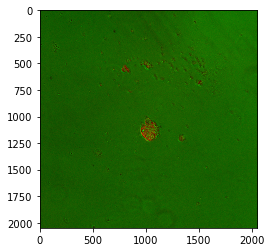

fitc
9 regions


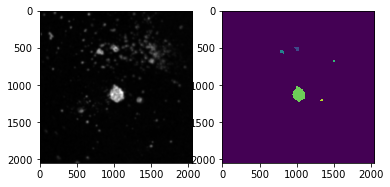

3 regions after filtering using min size 50


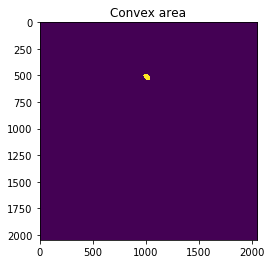

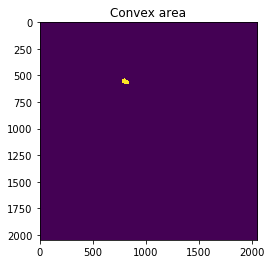

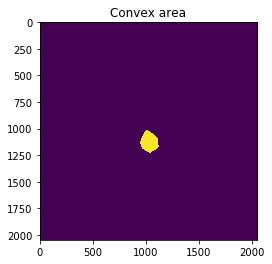

Z:\Sebastien\Neurospheres_melina_sebastien\96-wells\96-wells_3\DIV3_MT200527\GFAP-GFP_her-dRFP_P4_96wells_10X_1000-w1.czi
Z:\Sebastien\Neurospheres_melina_sebastien\96-wells\96-wells_3\DIV3_MT200527\GFAP-GFP_her-dRFP_P4_96wells_10X_1000-w1.czi
(2, 2048, 2048)


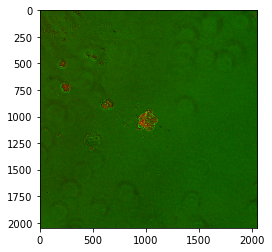

fitc
5 regions


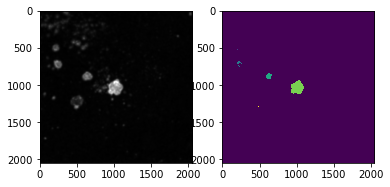

3 regions after filtering using min size 50


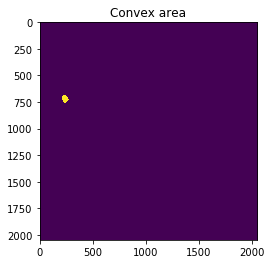

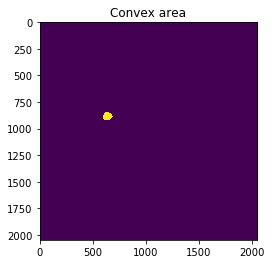

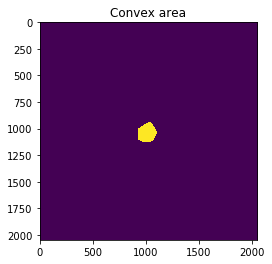

Z:\Sebastien\Neurospheres_melina_sebastien\96-wells\96-wells_3\DIV3_MT200527\GFAP-GFP_her-dRFP_P4_96wells_10X_1000-w10.czi
Z:\Sebastien\Neurospheres_melina_sebastien\96-wells\96-wells_3\DIV3_MT200527\GFAP-GFP_her-dRFP_P4_96wells_10X_1000-w10.czi
(2, 2048, 2048)


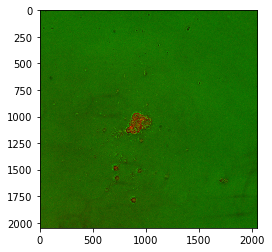

fitc
8 regions


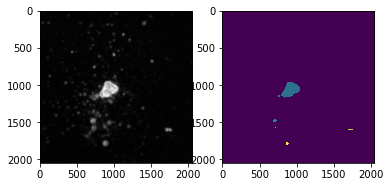

2 regions after filtering using min size 50


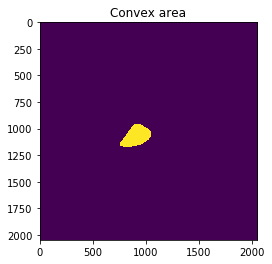

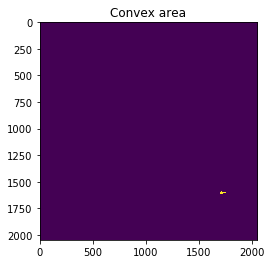

In [10]:
results = pd.DataFrame()
for f in flist[:3]:
    print(f)
    div, mt, cell_number, well = re.compile('(DIV\d)_(MT\d*).*_10X_(\d*)-(w\d*)').findall(f)[0]
    rgb = read_czi(f, plot=True)
    result = process_2_colors(rgb, plot=True, min_size=50, div=div, mt=mt, cell_number=cell_number, well=well)
    results = pd.concat((results, result))


In [27]:
results = pd.DataFrame()
for f in flist[:]:
    div, mt, cell_number, well = re.compile('(DIV\d)_(MT\d*).*_10X_(\d*)-(w\d*)').findall(f)[0]
    rgb = read_czi(f, plot=False)
    result = process_2_colors(rgb, plot=False, min_size=50, div=div, mt=mt, cell_number=cell_number, well=well)
    results = pd.concat((results, result))


Z:\Sebastien\Neurospheres_melina_sebastien\96-wells\96-wells_3\DIV1_MT200525\GFAP-GFP_her-dRFP_P4_96wells_10X_100-w1.czi
(2, 2048, 2048)
fitc
3 regions
1 regions after filtering using min size 50
Z:\Sebastien\Neurospheres_melina_sebastien\96-wells\96-wells_3\DIV1_MT200525\GFAP-GFP_her-dRFP_P4_96wells_10X_100-w10.czi
(2, 2048, 2048)
fitc
5 regions
3 regions after filtering using min size 50
Z:\Sebastien\Neurospheres_melina_sebastien\96-wells\96-wells_3\DIV1_MT200525\GFAP-GFP_her-dRFP_P4_96wells_10X_100-w11.czi
(2, 2048, 2048)
fitc
6 regions
3 regions after filtering using min size 50
Z:\Sebastien\Neurospheres_melina_sebastien\96-wells\96-wells_3\DIV1_MT200525\GFAP-GFP_her-dRFP_P4_96wells_10X_100-w12.czi
(2, 2048, 2048)
fitc
4 regions
2 regions after filtering using min size 50
Z:\Sebastien\Neurospheres_melina_sebastien\96-wells\96-wells_3\DIV1_MT200525\GFAP-GFP_her-dRFP_P4_96wells_10X_100-w13.czi
(2, 2048, 2048)
fitc
6 regions
1 regions after filtering using min size 50
Z:\Sebastien\Neu

In [37]:
results

path     size_px   area  \
0   Z:\Sebastien\Neurospheres_melina_sebastien\96-...   90.995658   2043   
0   Z:\Sebastien\Neurospheres_melina_sebastien\96-...  137.694490   7666   
1   Z:\Sebastien\Neurospheres_melina_sebastien\96-...  169.745459   7395   
2   Z:\Sebastien\Neurospheres_melina_sebastien\96-...   56.937006    988   
0   Z:\Sebastien\Neurospheres_melina_sebastien\96-...   52.208594   1816   
..                                                ...         ...    ...   
1   Z:\Sebastien\Neurospheres_melina_sebastien\96-...  123.719645   9125   
0   Z:\Sebastien\Neurospheres_melina_sebastien\96-...  162.508529  13109   
0   Z:\Sebastien\Neurospheres_melina_sebastien\96-...   57.188178   1842   
1   Z:\Sebastien\Neurospheres_melina_sebastien\96-...  163.364673  14216   
0   Z:\Sebastien\Neurospheres_melina_sebastien\96-...   58.589883   1594   

     perimeter  circularity  convex_area  convex_eccentricity  \
0   239.758405     0.035540         2853             0.899955   
0   401.102597     0.047649         9100             0.748600   
1   480.031529     0.032092        10403             0.855416   
2   151.882251     0.042829         1197             0.876180   
0   162.568542     0.068714         1854             0.507334   
..         ...          ...          ...                  ...   
1   392.232539     0.059312         9713             0.530135   
0   486.859956     0.055305        14157             0.709199   
0   174.296465     0.060633         1917             0.668964   
1   511.705627     0.054292        15680             0.655058   
0   158.911688     0.063121         1653             0.777525   

    convex_perimeter  convex_circularity        tritc          fitc  index  \
0         232.007143            0.053003  1727.511041  16431.217666      0   
0         387.386868            0.060639  1523.928242  18127.369890      0   
1         430.776695            0.056060  1529.400173  18815.359319      1   
2         146.911688            0.055460  1613.874687  18891.974937      2   
0         162.568542            0.070151  2142.806365  16085.577131      0   
..               ...                 ...          ...           ...    ...   
1         389.060967            0.064168  1207.536292  15854.274683      1   
0         480.173665            0.061401  1364.929364  14532.446705      0   
0         174.710678            0.062803   914.114241  14353.154408      0   
1         487.220346            0.066053  1029.905485  13059.406314      1   
0         158.911688            0.065458   908.490018  14158.422263      0   

     div        mt cell_number well  tritc/fitc     size_um      circ  \
0   DIV1  MT200525         100   w1    0.105136   59.147178  0.446612   
0   DIV1  MT200525         100  w10    0.084068   89.501419  0.598781   
1   DIV1  MT200525         100  w10    0.081285  110.334549  0.403282   
2   DIV1  MT200525         100  w10    0.085426   37.009054  0.538211   
0   DIV1  MT200525         100  w11    0.133213   33.935586  0.863481   
..   ...       ...         ...  ...         ...         ...       ...   
1   DIV6  MT200530         600   w6    0.076165   80.417769  0.745342   
0   DIV6  MT200530         600   w7    0.093923  105.630544  0.694978   
0   DIV6  MT200530         600   w8    0.063687   37.172315  0.761943   
1   DIV6  MT200530         600   w8    0.078863  106.187037  0.682255   
0   DIV6  MT200530         600   w9    0.064166   38.083424  0.793207   

    conv_circ  
0    0.666053  
0    0.762011  
1    0.704473  
2    0.696933  
0    0.881549  
..        ...  
1    0.806358  
0    0.771586  
0    0.789211  
1    0.830052  
0    0.822567  

[973 rows x 20 columns]

In [29]:
results['tritc/fitc'] = results.tritc / results.fitc
results['size_um'] = results.size_px * .65
results['circ'] = results.circularity * 4 * np.pi
results['conv_circ'] = results.convex_circularity * 4 * np.pi

data = results.query('size_px < 600')


In [36]:
results.to_csv(r'Z:\Sebastien\Neurospheres_melina_sebastien\96-wells\96-wells_3/results_all_cells.csv')

In [30]:
def plot(data, x='div', y='fitc', hue='cell_number', size=3):
    fig, ax = plt.subplots(dpi=150)
    ax.set_title(y.upper())

    sns.swarmplot(data=data, x=x, y=y, hue=hue, dodge=1, size=size)
    sns.boxplot(data=data, x=x, y=y, hue=hue, dodge=1, boxprops=dict(alpha=.3))
    plt.legend(loc=(1,0))
    plt.show()

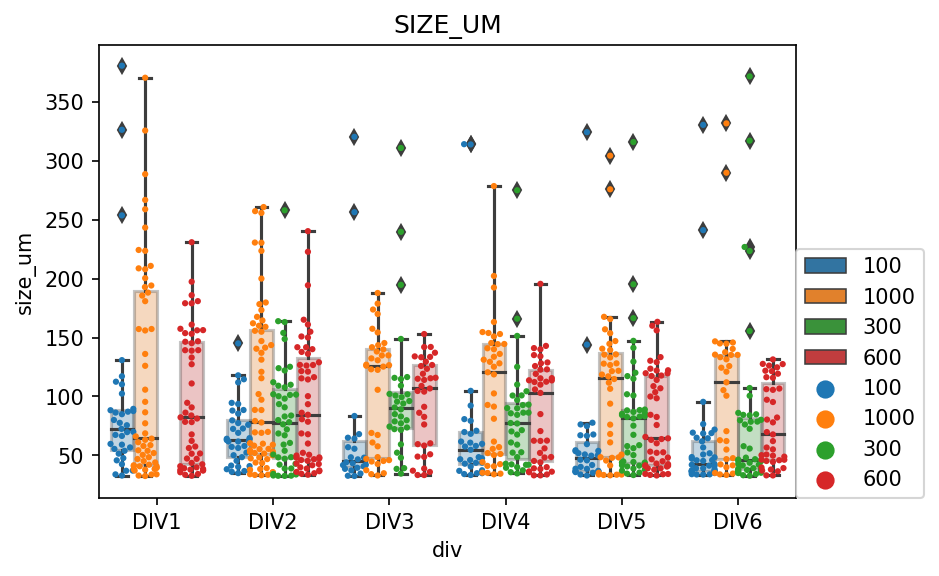

In [31]:

plot(data, y='size_um')

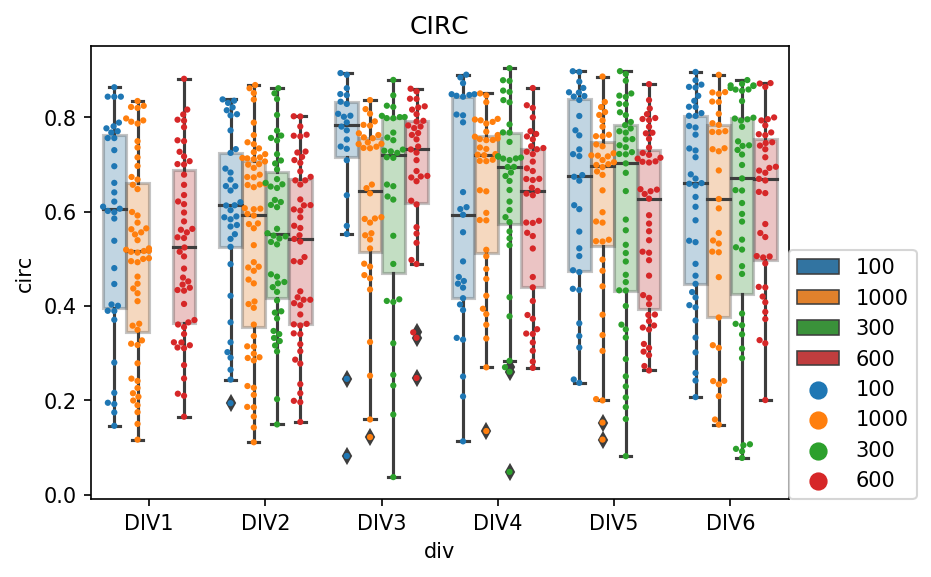

In [32]:
plot(data, y='circ')

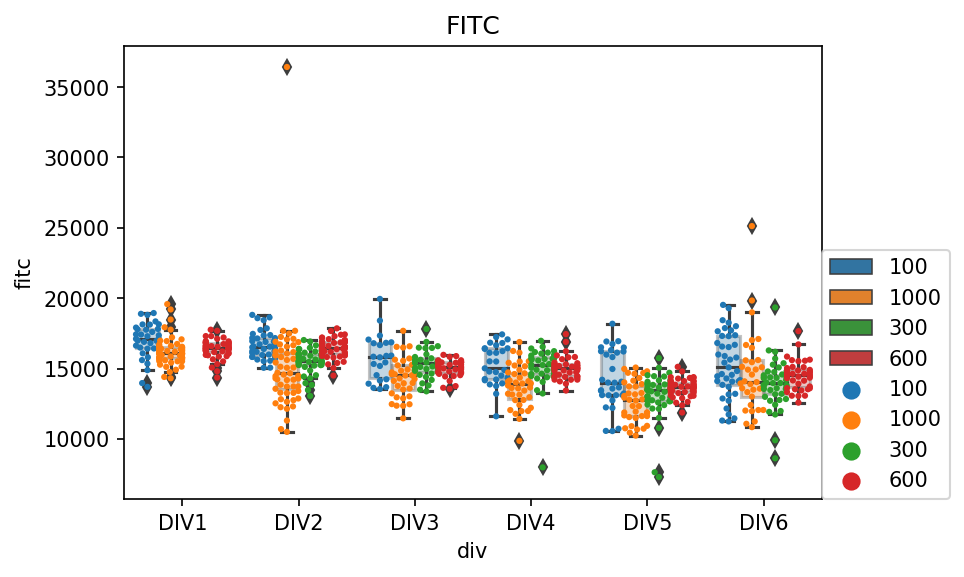

In [33]:
plot(data, y='fitc', size=3)

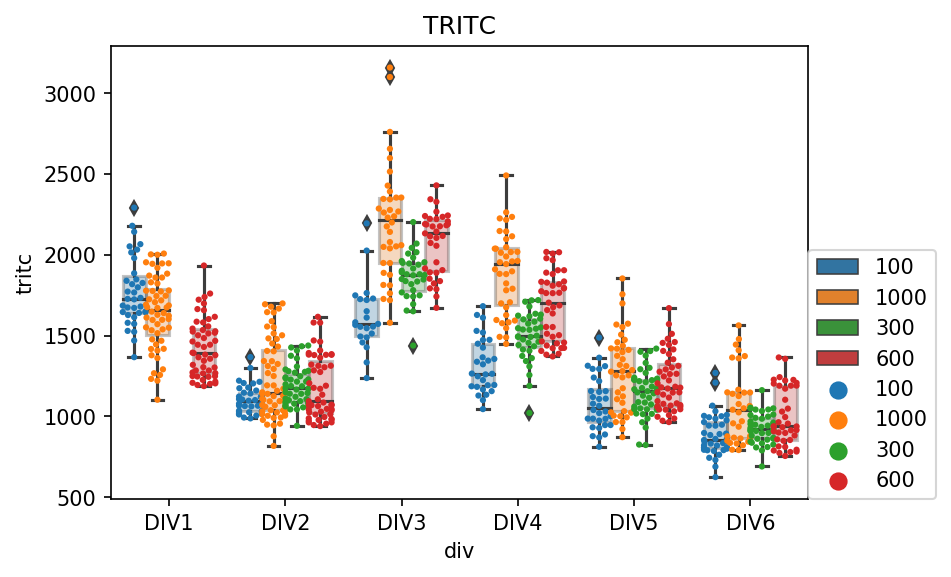

In [34]:
plot(data, y='tritc')

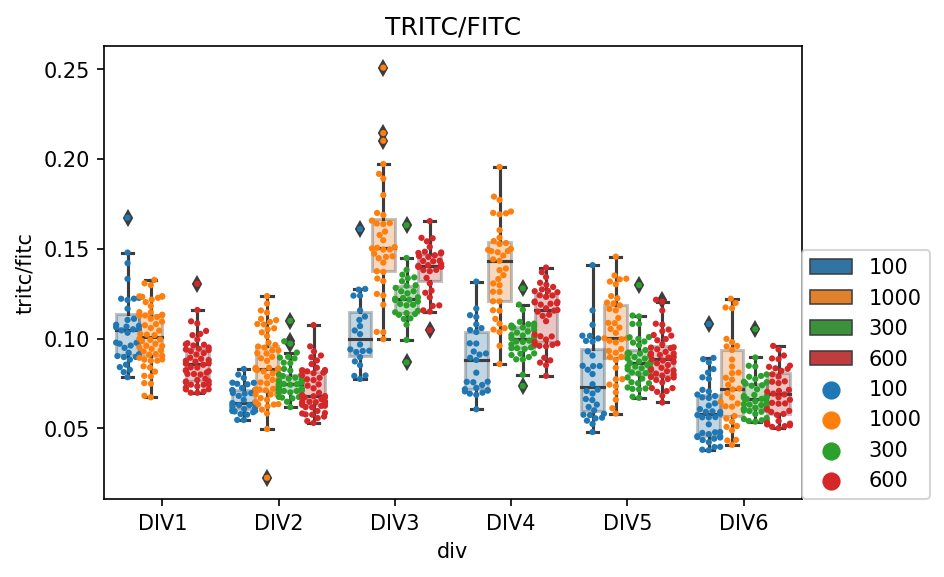

In [35]:
plot(data, y='tritc/fitc')